# Kaggle - House Prices - Advanced Regression Techniques
    by Pertseva Anastasiya

## 1. Загрузка библиотек и данных

In [1]:
import pandas as pd # работа с датафреймами
import numpy as np # векторная алгебра

from scipy import stats # тесты

import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # тоже для визуализации, надстройка над предыдущим

from sklearn import preprocessing  # предобработка данных
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV # линейные модели

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split # для кроссвалидация

from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error 

from category_encoders import *

from typing import List

pd.set_option('display.max_columns', None) # параметр, настраивающий видимое число столбцов в Юпитер-ноутбуке

In [9]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'

In [3]:
data = pd.read_csv(TRAIN_FILENAME, index_col='Id')

data_test = pd.read_csv(TEST_FILENAME, index_col='Id')

In [4]:
# перечисление категориальных признаков
def get_cat_features(df: pd.DataFrame) -> List[str]:
    """Получение списка категориальных признаков."""
    # Добавляем целочисленные категориальные признаки в список
    cat_features = ['MSSubClass'] #, 'OverallQual', 'OverallCond', 'YrSold', 'MoSold']

    # Добавляем строчные или пустые (проверено руками, что категориальные) 
    # признаки по значениям первой строки
    for col, val in zip(df.columns, df.iloc[1,:]):
        if isinstance(val, str) == True or np.isnan(val):
            cat_features.append(col)

    return cat_features

## 2. Исследование данных

In [5]:
# Получаем список категориальных признаков
cat_features_general = get_cat_features(data)

In [6]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
data.shape

(1460, 80)

### Описательные статистики

In [8]:
# описательные статистики по столбцам
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Уникальные значения

Проверяем, насколько адекватны признаки, у которых всего два уникальных значения. 1. Должны ли они быть бинарными? 2. Какое соотношение числа уникальных значений - если слишком малое, то исключаем признак, т.к. признак практически константа получается.

In [9]:
nunique = data.nunique()
nunique[nunique == 2]

Street        2
Alley         2
Utilities     2
CentralAir    2
dtype: int64

In [10]:
data['Utilities'].unique()

array(['AllPub', 'NoSeWa'], dtype=object)

In [11]:
data_test['Utilities'].unique()

array(['AllPub', nan], dtype=object)

Utilities - не бинарный признак (по описанию), но на обучающей выборке принимает всего два значения, а на тестовой - одно при двух пропущенных значениях -> попадает в список на исключение. 

In [12]:
features_to_drop = ['Utilities']

### Пропущенные значения

In [13]:
# Считаем пропущенные значения для обучающей выборки
na_count = data.isna().sum()
na_count[na_count > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [14]:
# Считаем пропущенные значения для тестовой выборки
na_count = data_test.isna().sum()
na_count[na_count > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

Исключаем: PoolQC, MiscFeature, т.к. слишком много пропущенных значений, и целевую переменную SalePrice.
Для Alley, FireplaceQu, Fence значение NaN это одно из категориальных значений, пробуем оставить. Для них значения NaN необходимо будет заменить специальным значением. 

In [15]:
features_to_drop.extend(['PoolQC', 'MiscFeature', 'SalePrice'])

In [ ]:
# def space_processing(df: pd.DataFrame, cat_features_idx: List[int]) -> pd.DataFrame:
#     """Заполнение пропусков в датафрейме: категориальные заполняются модой,
#     количественные - медианой"""
    
#     for col in df.columns:
#         value = df[col].mode()[0] if df.columns.get_loc(col) in cat_features_idx else df[col].median()
#         df[col] = df[col].fillna(value)
#     return df

In [16]:
# Для данной выборки проход по столбцам был бы чуть быстрее, 
# но для больших выборок данный вариант оптимальнее
def space_processing(df: pd.DataFrame, cat_features: List[str]) -> pd.DataFrame:
    """Заполнение пропусков в датафрейме: категориальные заполняются модой,
    количественные - медианой, признаки Alley, FireplaceQu, Fence - 
    специальными текстовыми значениями. 
    
    Параметры:
    df - датафрейм
    cat_features - список названий категориальных признаков"""
    
    na_dict_cat = {col: df[col].mode()[0] for col in list(set(cat_features) - {'Alley', 'FireplaceQu', 'Fence'})}
    
    num_features = list(set(df.columns) - set(cat_features))
    na_dict_num = {col: df[col].median() for col in num_features}
    
    na_dict_spec = {'Alley': 'N', 'FireplaceQu': 'N', 'Fence': 'N'}
    
    df = df.fillna({**na_dict_cat, **na_dict_num, **na_dict_spec})
    return df

### Выбросы в признаках

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


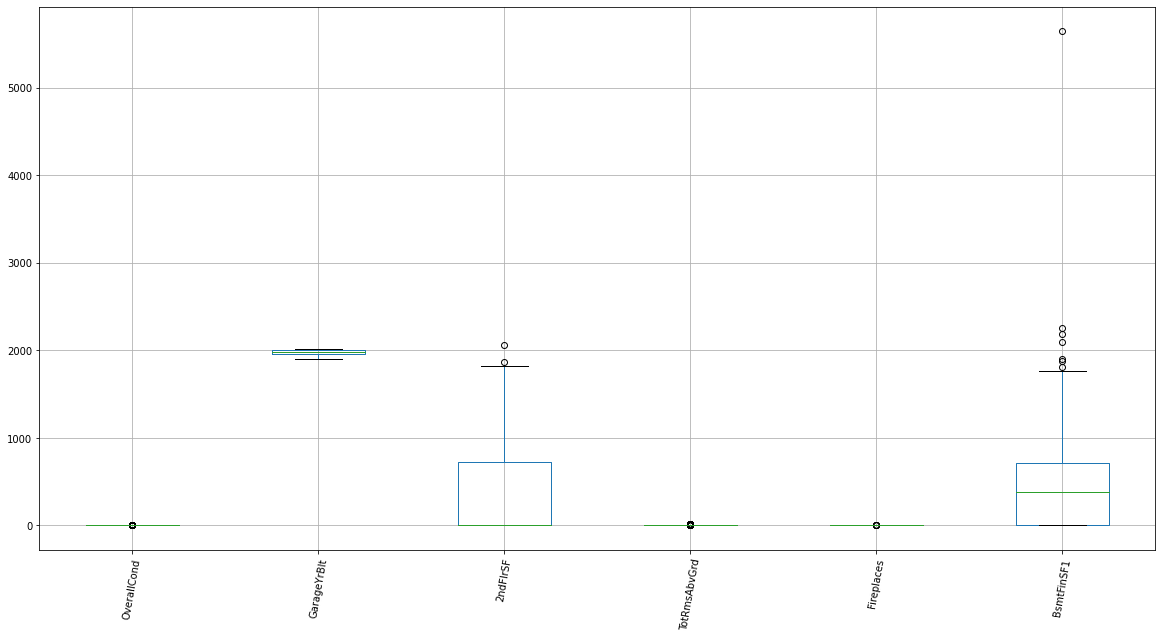

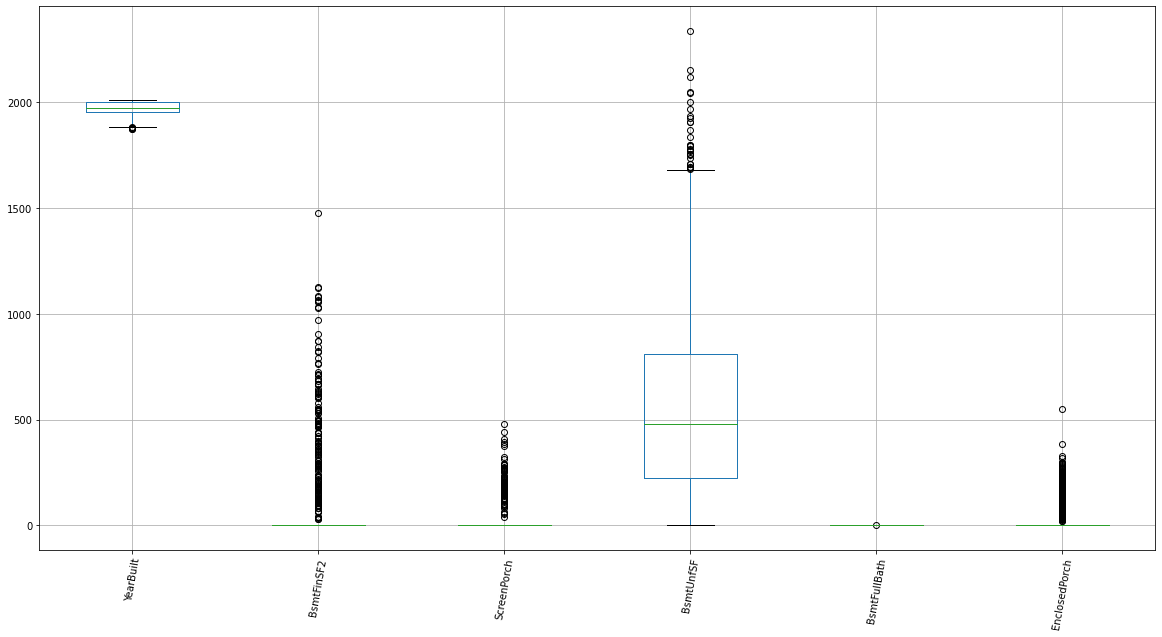

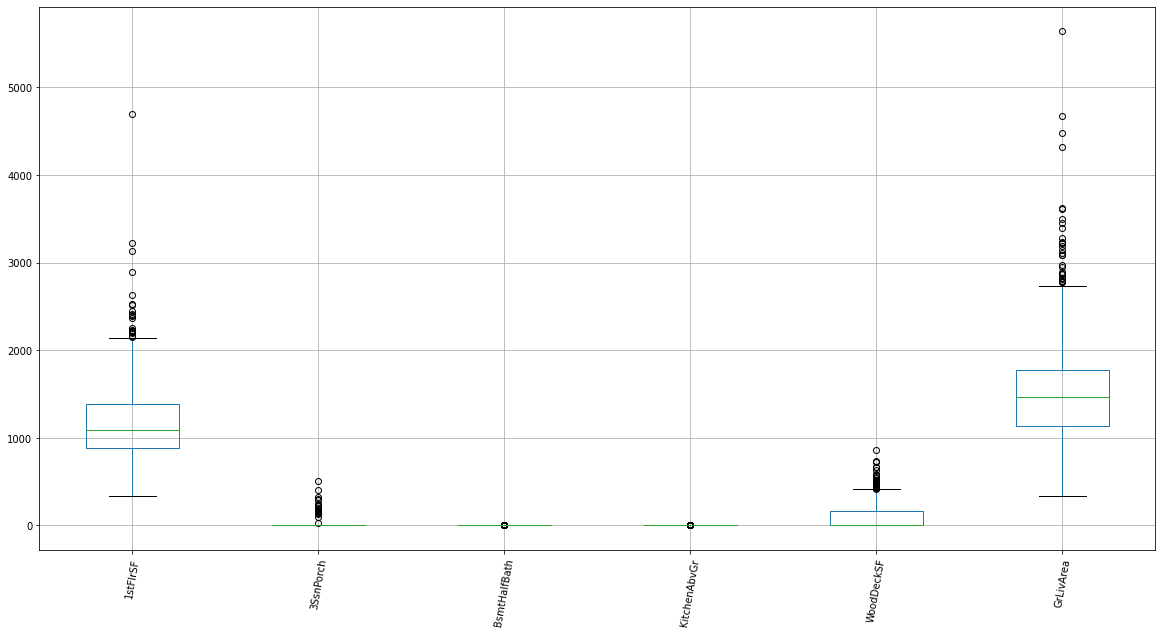

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


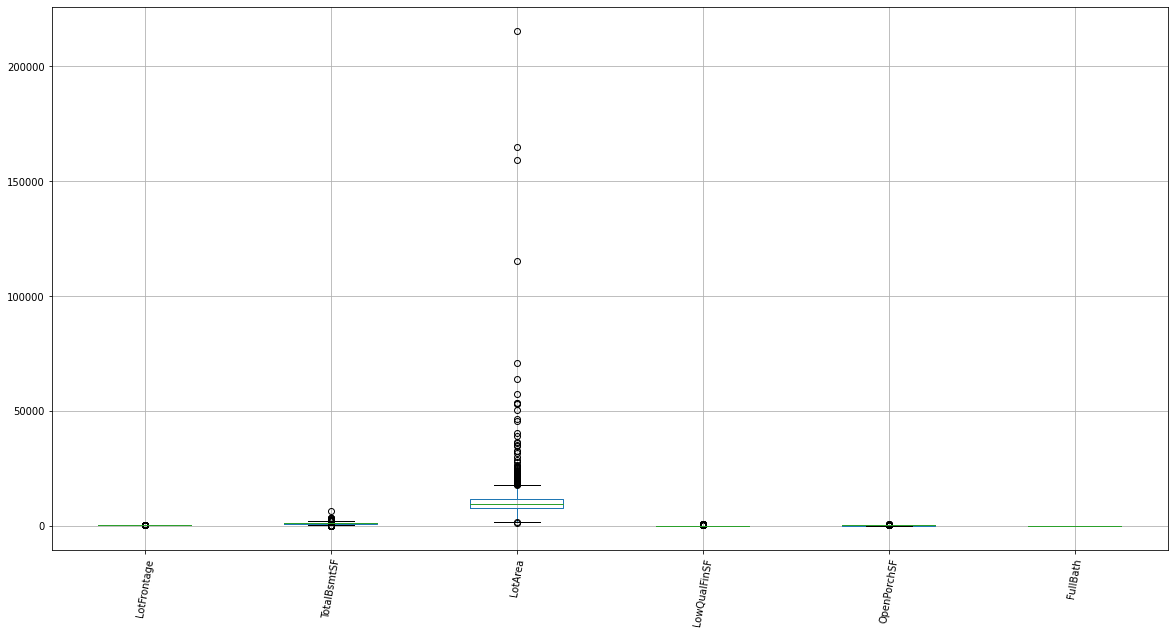

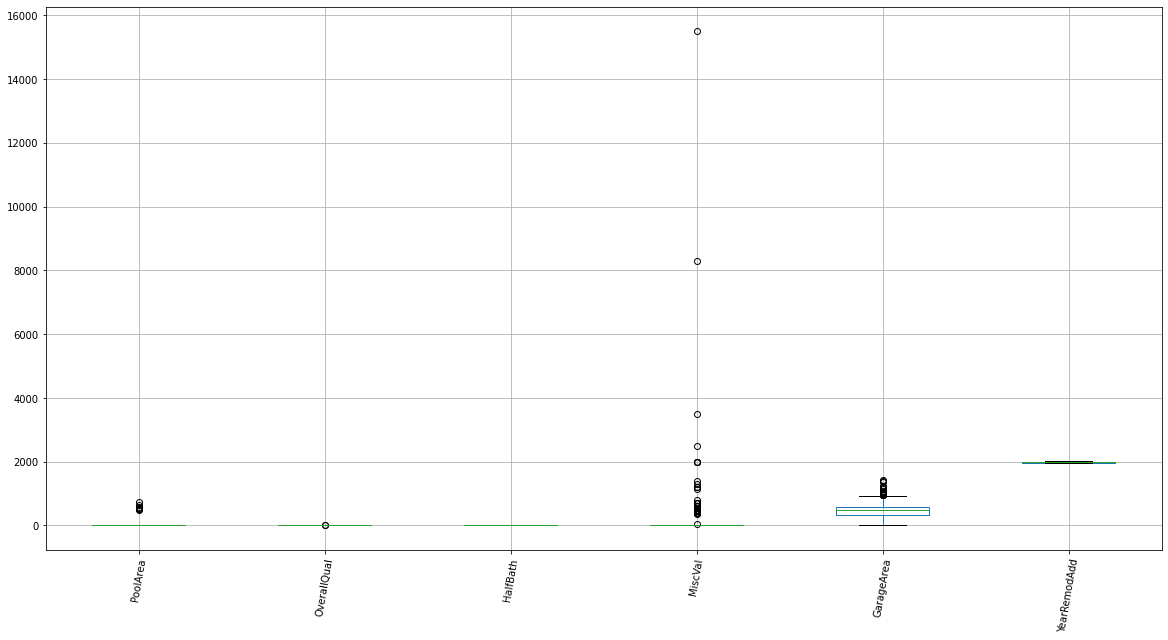

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


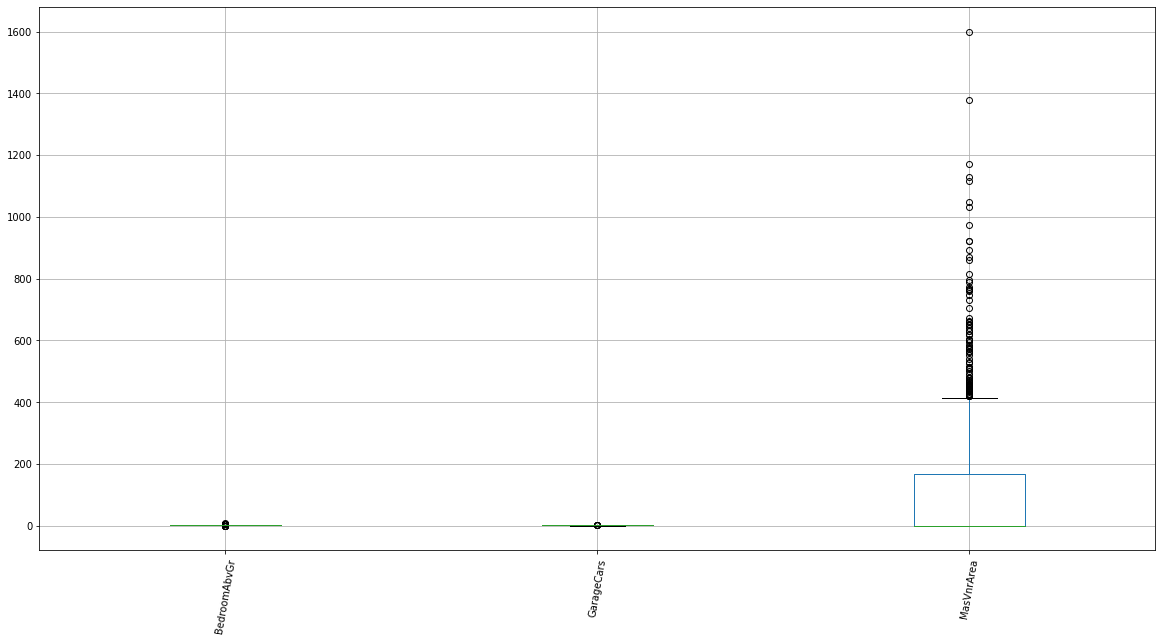

In [17]:
# боксплоты, проверка на выбросы
num_features = list(set(data.columns) - set(cat_features_general) - set(['PoolQC', 'MiscFeature', 'SalePrice','OverallQual' 
                                                                'OverallCond', 'MoSold', 'YrSold', 'Utilities']))
data_num = data[num_features]
for i in range(0,data_num.shape[1],6):
    plt.figure(figsize=(20, 10))
    data_num.iloc[:,i:i+6].boxplot(rot=80)
    plt.show()

In [19]:
# Определяем границы выбросов - выше третьего квартиля и
# ниже первого
Q1 = data[num_features].quantile(0.25)
Q3 = data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bounds = Q1 - 1.5 * IQR
upper_bounds = Q1 + 1.5 * IQR

# Заменяем аномальные значения на граничные
data_train = pd.DataFrame(data[:])
for col in num_features:
    data_train.loc[data_train[col] < lower_bounds[col],col] = lower_bounds[col]
    data_train.loc[data_train[col] > upper_bounds[col],col] = upper_bounds[col]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


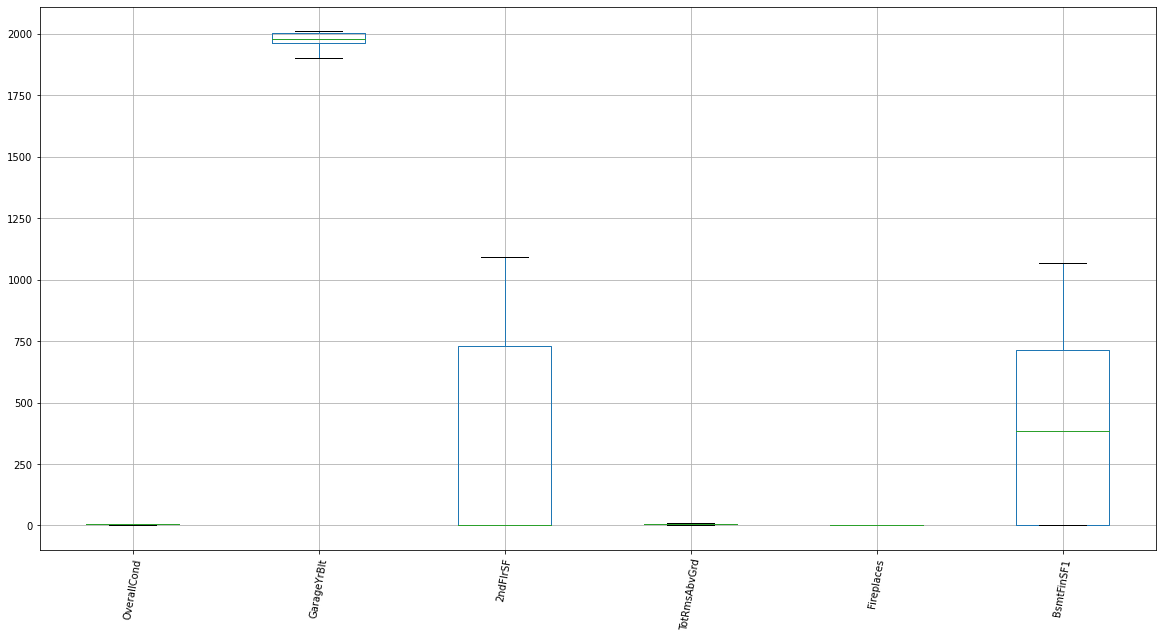

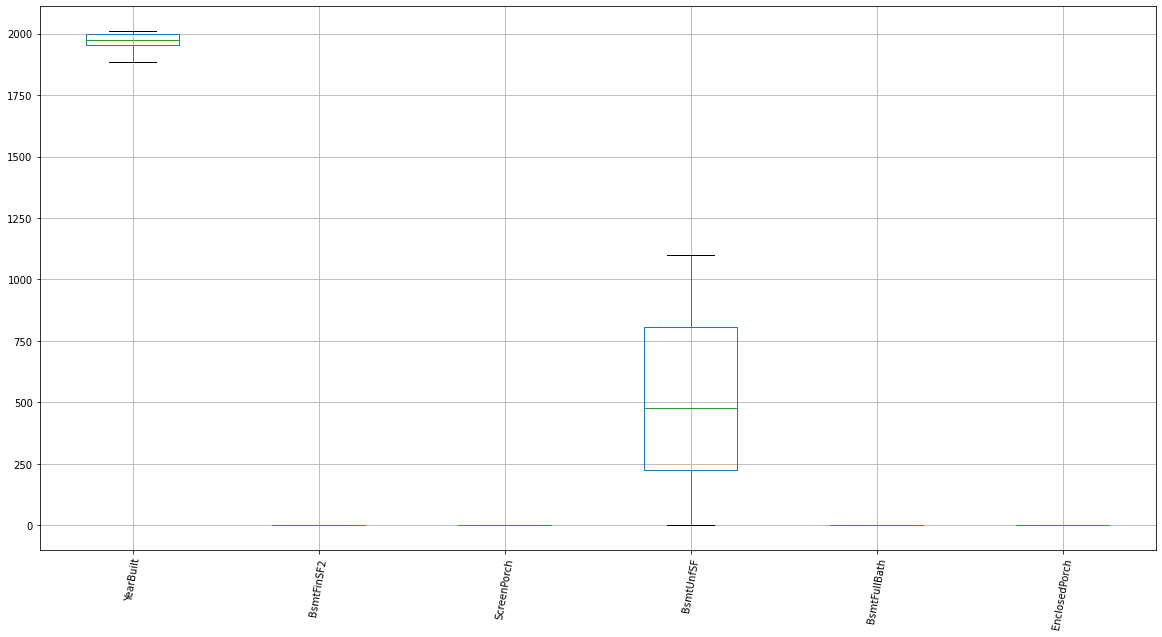

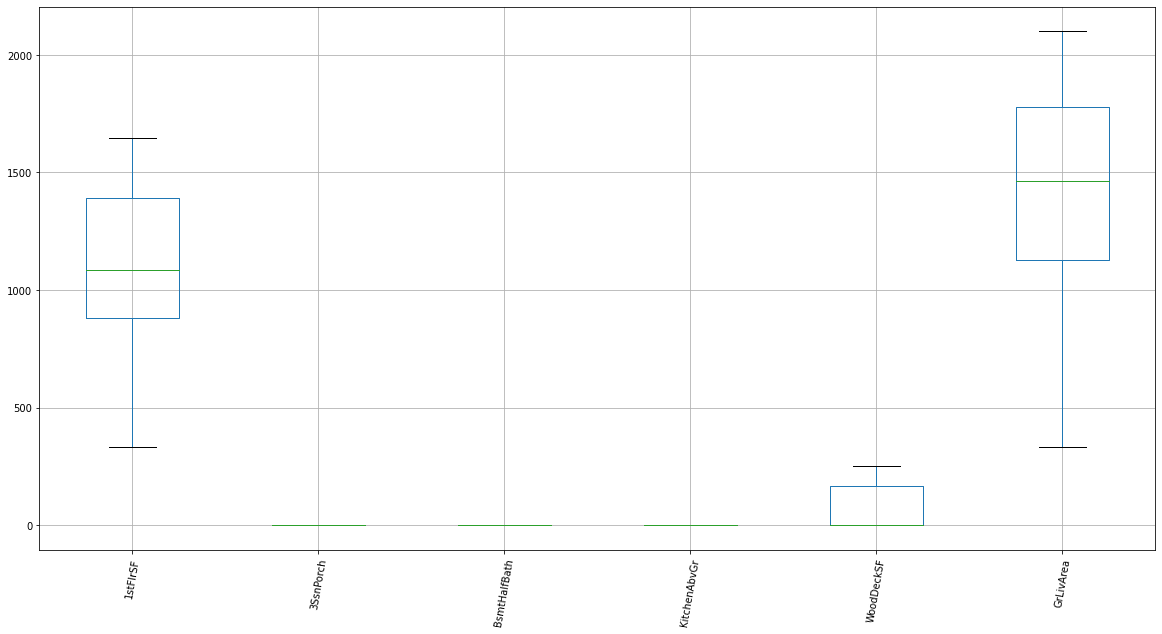

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


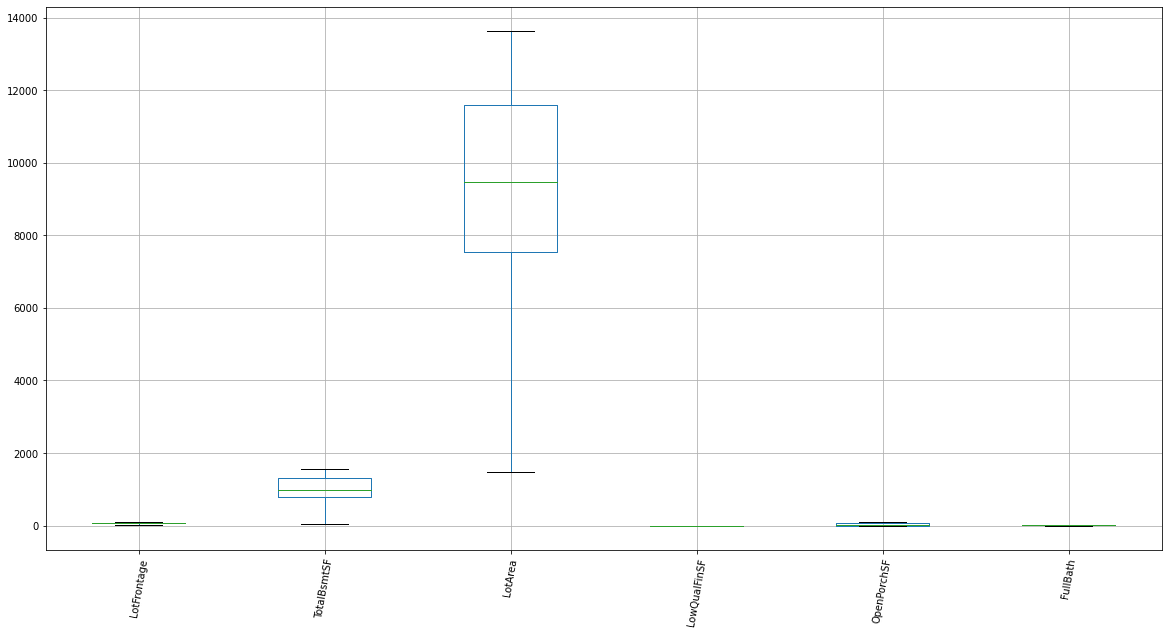

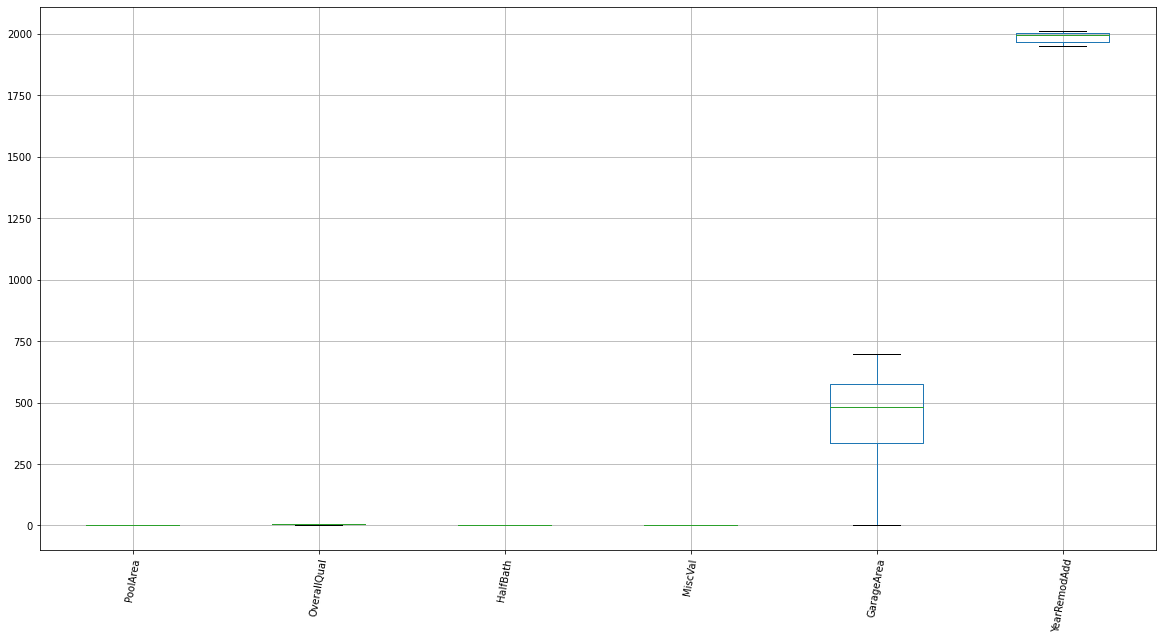

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


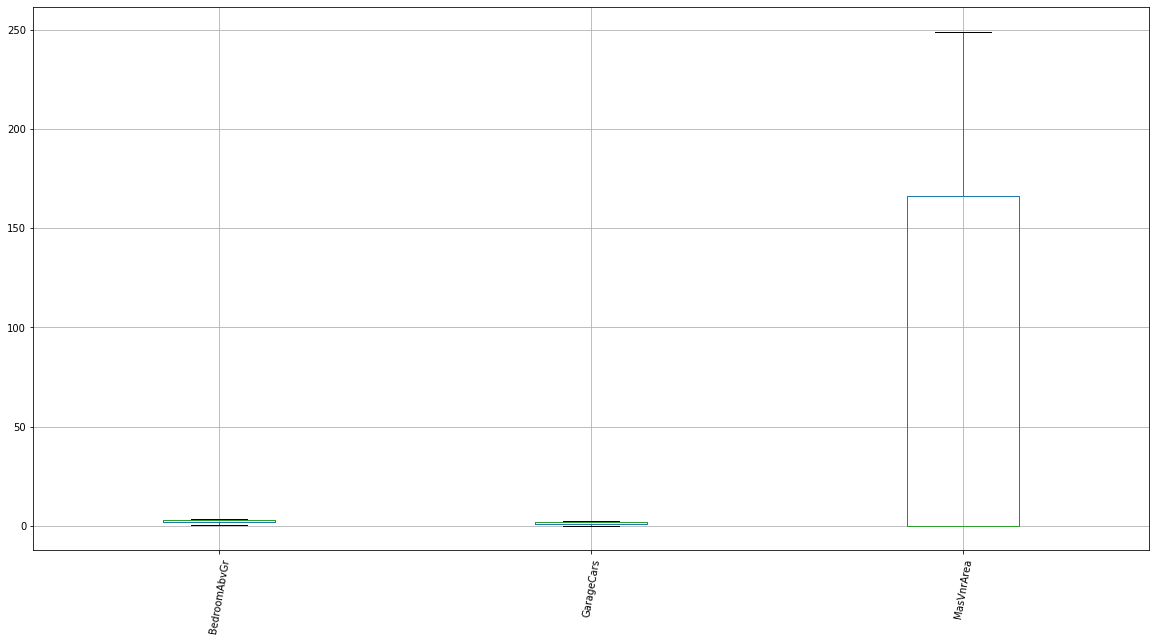

In [20]:
data_num = data_train[num_features]
for i in range(0,data_num.shape[1],6):
    plt.figure(figsize=(20, 10))
    data_num.iloc[:,i:i+6].boxplot(rot=80)
    plt.show()

#### Аналогично делаем для тестовой выборки

In [21]:
# Определяем границы выбросов - выше третьего квартиля и ниже первого
# Границы для тестовой выборки берем такие же, как и для обучающей
Q1 = data[num_features].quantile(0.25)
Q3 = data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bounds = Q1 - 1.5 * IQR
upper_bounds = Q1 + 1.5 * IQR

# Заменяем аномальные значения на граничные
data_test_ = pd.DataFrame(data_test[:])
for col in num_features:
    data_test_.loc[data_test_[col] < lower_bounds[col],col] = lower_bounds[col]
    data_test_.loc[data_test_[col] > upper_bounds[col],col] = upper_bounds[col]

### Целевая переменная


 mu = 180921.20 and sigma = 79415.29



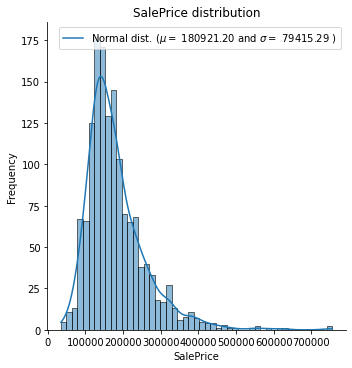

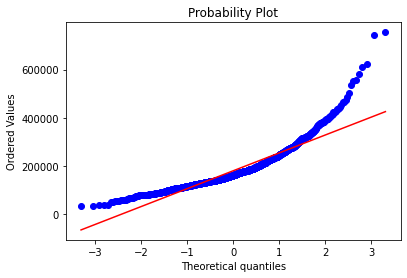

In [22]:
target = data['SalePrice']

# Получаем параметры распределения целевой переменной
(mu, sigma) = stats.norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Строим график распределения целевой переменной - получается смещенный
sns.displot(target, kde=True)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Строим график вероятностей
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



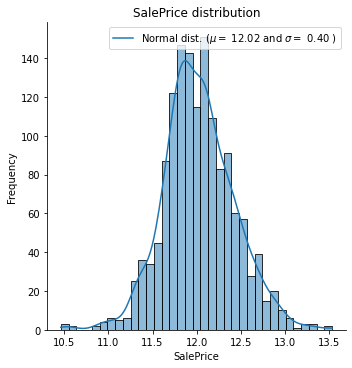

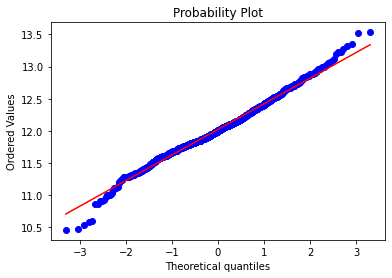

In [23]:
# Логарифмируем целевую переменную
target = np.log(data['SalePrice'])

# Получаем параметры распределения целевой переменной
(mu, sigma) = stats.norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Строим график распределения целевой переменной - получается смещенный
sns.displot(target, kde=True)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Строим график вероятностей
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()

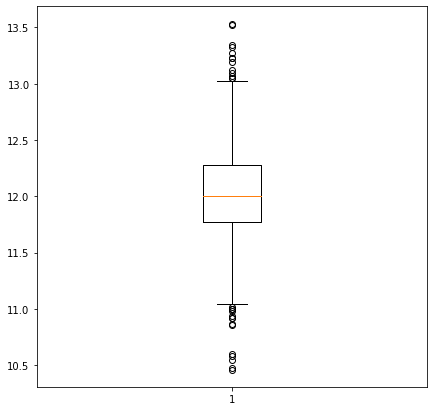

In [24]:
plt.figure(figsize=(7, 7))
plt.boxplot(target)
plt.show()

In [25]:
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1

lower_bounds = Q1 - 1.5 * IQR
upper_bounds = Q1 + 3 * IQR

idx_to_del = np.concatenate([list(target[target < lower_bounds].index), list(target[target > upper_bounds].index)])

### Обработка категориальных переменных
Для дальнейшего исследования необходимо обработать категориальные данные

In [26]:
# Удаляем выбранные признаки и обрабатываем пропущенные значения
data_train = data_train.drop(features_to_drop, axis=1)

# Получаем список категориальных признаков
cat_features = get_cat_features(data_train)
data_train = space_processing(data_train, cat_features)

In [27]:
# Используем кодировку LeaveOneOutEncoder для борьбы с возможными выбросами
target_encoder = TargetEncoder(cols=cat_features).fit(data_train, target)
data_train = target_encoder.transform(data_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


#### Аналогично для тестовой выборки

In [28]:
data_test_ = data_test_.drop(['Utilities', 'PoolQC', 'MiscFeature'], axis=1)
data_test_ = space_processing(data_test_, cat_features)
data_test_ = target_encoder.transform(data_test_)

In [29]:
data_all = pd.concat([data_train, data_test_])

### Корреляции
Находим факторы с корреляцией >= 0.8, из двух оставляем только один.

In [30]:
# Провека корреляций 
corrs_arr = []
  
for i in data_all.columns:
    for j in data_all.columns[data_all.columns.get_loc(i)+1:-1]:
        if i != j and abs(stats.pearsonr(data_all[i], data_all[j])[0]) >= 0.8:
            corrs_arr.append([i, j, stats.pearsonr(data_all[i], data_all[j])[0]])

corrs = pd.DataFrame(corrs_arr, columns=['Feature 1', 'Feature 2', 'Коэффициент корреляции'])
corrs

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,Feature 1,Feature 2,Коэффициент корреляции
0,Exterior1st,Exterior2nd,0.911996
1,Fireplaces,FireplaceQu,0.890445
2,GarageCars,GarageArea,0.903243


Следующий код выполнялся после выполнения раздела 3 - Важность признаков. Среди двух коррелирующих признаков отбрасывается наименее важный по результатам работы модели catboost, эти оценки хранятся в переменной feature_importances. 

In [35]:
features_to_drop2 = []
for corr in corrs.values:
    features_to_drop2.append(feature_importances.loc[[corr[0], corr[1]], :].idxmin()[0])

In [36]:
features_to_drop2

['Exterior2nd', 'Fireplaces', 'GarageCars']

#### VIF - коэффициент инфляции дисперсии, показывает наличие мультиколлинеарности (линейных комбинаций признаков). Критическое значение возьмем 5.

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [38]:
X = add_constant(data_all.drop(features_to_drop2, axis=1))
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
features_to_drop3 = list(vif[vif>5].index)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [39]:
features_to_drop3

['YearBuilt',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'KitchenAbvGr']

### Сравнение распределений обучающей и тестовой выборок

#### Критерий Стьюдента

In [41]:
pvals = pd.Series()
num_features_general = list(set(data_test.columns) - set(cat_features_general))
for col in data[num_features_general].columns:
    mean1 = data1[col].mean()
    mean2 = data2[col].mean()
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    SE = np.sqrt( ((np.sum((data1[col]-mean1)**2) + np.sum((data2[col]-mean2)**2)) * (n1 + n2)) / (n1 * n2 * (n1 + n2 - 2)) )
    t_stat = (mean1 - mean2) / SE
    df = n1 + n2 - 2
    pvals.loc[col] = stats.t.sf(t_stat, df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
pvals[pvals < 0.05]

TotRmsAbvGrd    0.011212
LotArea         0.008421
MoSold          0.015119
3SsnPorch       0.041611
dtype: float64

In [ ]:
features_to_drop5 = ['TotRmsAbvGrd', 'LotArea', 'MoSold']

У нескольких переменных p-value получился меньше 0.05 (4 переменных) и даже меньше 0.01 (1 переменная), это значит, что у этих переменных распределения достаточно отличаются. 

#### Индекс стабильности популяции -  PSI

In [43]:
def continuous2interval(df, df_target, percent_interval=0.1):
    special_target = []
    interval_target = []
    begin = False
    temp_percent = 0
    for index, row in (df[df_target].value_counts(normalize=True)).reset_index().sort_values(by='index').iterrows():
        if row[df_target] >= percent_interval:
            special_target.append(row['index'])
        else:
            temp_percent += row[df_target]
            if begin == False:
                begin = row['index']
            if temp_percent >= percent_interval:
                interval_target.append([begin, row['index']])
                begin = False
                temp_percent = 0
    if begin != False:
        interval_target.append([begin, np.inf])
    return interval_target, special_target

def PSI_factor_analysis(dev, val, column):
    intervals = [-np.inf] + [i[0] for i in continuous2interval(dev, column)[0]] + [np.inf]
    dev_temp = pd.cut(dev[column], intervals).value_counts(sort=False, normalize=True)
    val_temp = pd.cut(val[column], intervals).value_counts(sort=False, normalize=True)
    return sum(((dev_temp - val_temp)*np.log(dev_temp / val_temp)).replace([np.inf, -np.inf], 0))

In [44]:
psi= {}
data1 = space_processing(data, cat_features_general)
data2 = space_processing(data_test, cat_features_general)
num_features_general = list(set(data_test.columns) - set(cat_features_general))
for col in data[num_features_general].columns:
    psi[col] = PSI_factor_analysis(data1, data2, col)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
psi

{'OverallCond': nan,
 'GarageYrBlt': 0.011315040212445426,
 '2ndFlrSF': 0.012054093822221756,
 'TotRmsAbvGrd': 0.0022385747436545695,
 'Fireplaces': 0.0004648607349578144,
 'BsmtFinSF1': 0.0579742220121179,
 'YearBuilt': nan,
 'BsmtFinSF2': 0.013723224507188376,
 'ScreenPorch': 0.0037167873120878096,
 'BsmtUnfSF': 0.06499163761109733,
 'BsmtFullBath': 4.692919038332373e-07,
 'EnclosedPorch': 0.009274702405607387,
 '1stFlrSF': 0.007886098597637628,
 '3SsnPorch': 0.00394708523568361,
 'BsmtHalfBath': 1.8778111421626911e-06,
 'KitchenAbvGr': 1.8778111421626911e-06,
 'WoodDeckSF': 0.0028368716000865745,
 'GrLivArea': 0.020243237207490227,
 'LotFrontage': 0.012372456735968915,
 'TotalBsmtSF': 0.06991357698901397,
 'LotArea': 0.012813699699854865,
 'LowQualFinSF': 0.004416960474690981,
 'YrSold': 0.0,
 'OpenPorchSF': 0.003283885969274358,
 'MoSold': 0.009690097208690445,
 'FullBath': 7.526713960775253e-06,
 'PoolArea': 0.003014510234123252,
 'OverallQual': nan,
 'HalfBath': nan,
 'MiscVal': 

Индекс стабильности популяции меньше 0.1, значит, что распределение выборкок не сильно изменилось.

## 3. Важность признаков

Строим градиентный бустинг на основе CatBoost - данная библиотека умеет работать с категориальными признаками и пропусками. Потом по атрибуту feature_importances_ выберем наиболее значимые признаки

In [31]:
data_train_norm = preprocessing.StandardScaler().fit_transform(data_train)
feature_selection_catboost =  CatBoostRegressor()
feature_selection_catboost.fit(data_train_norm, target, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
feature_importances = pd.DataFrame({'feature_importances': feature_selection_catboost.feature_importances_},
             index = data_train.columns) \
            .sort_values(by='feature_importances', ascending=False, axis=0)

feature_importances[feature_importances.feature_importances == 0]

,feature_importances
BsmtFinSF2,0.0
EnclosedPorch,0.0
3SsnPorch,0.0
ScreenPorch,0.0
PoolArea,0.0
MiscVal,0.0
KitchenAbvGr,0.0
LowQualFinSF,0.0
BsmtHalfBath,0.0


In [34]:
# Удаляем незначимые признаки, вклад которых равен нулю
features_to_drop4 = list(feature_importances[feature_importances.feature_importances == 0].index)

## 4. Предобработка данных
Создаем консолидированную функцию для обработки данных, состоящую из шагов, сделанных в рамках исследования данных.

In [46]:
def data_processing(df: pd.DataFrame, features_to_drop: List[str] = features_to_drop) -> pd.DataFrame:
    """ Обработка данных. 
    
    Параметры:
    df - датафрейм
    cat_features - список названий категориальных признаков"""
    
    # Исключаем: PoolQC, MiscFeature, Utilities  и SalePrice
    new_features_to_drop = features_to_drop[:]
    if 'SalePrice' not in df.columns:
        new_features_to_drop.remove('SalePrice')
    new_data = df.drop(new_features_to_drop, axis=1)

    # Получаем список категориальных признаков
    cat_features = get_cat_features(new_data)
    # заполняем пропущенные значения
    new_data = space_processing(new_data, cat_features)
    
    return new_data

#### Для того, чтобы не проделывать каждый раз работу по обработке данных вручную, собираем вышеописанные действия в класс DataTransform

In [80]:
class DataTransform(object):
    """"Класс предназначен для обработки данных перед обучением и предсказанием"""
    
    def __init__(self, features_to_drop: List[str]=[]):
        if len(features_to_drop) != 0:
            self.features_to_drop = features_to_drop
        else:
            self.features_to_drop = ['Utilities', 
                                'PoolQC', 
                                'MiscFeature', 
                                'BsmtHalfBath',
                                'EnclosedPorch',
                                '3SsnPorch',
                                'ScreenPorch',
                                'PoolArea',
                                'MiscVal',
                                'KitchenAbvGr',
                                'LowQualFinSF',
                                'BsmtFinSF2']
        self.cat_features = None
        self.na_dict = None
        self.lower_bounds = None
        self.upper_bounds = None
        
            
    def __get_idx_target_outlier(self, target: pd.Series):
        """Поиск индексов выбросов целевой переменной.
        Параметры:
        target - целевая переменная"""
        Q1 = target.quantile(0.25)
        Q3 = target.quantile(0.75)
        IQR = Q3 - Q1
        lower_bounds = Q1 - 1.5 * IQR
        upper_bounds = Q1 + 3 * IQR
        idx_to_drop = np.concatenate([list(target[target < lower_bounds].index), list(target[target > upper_bounds].index)])
        return idx_to_drop
    
    def __processing_features_outlier(self, df: pd.DataFrame) -> pd.DataFrame:
        """Обработка выбросов: значения ниже граничных значений 
        заменяются граничными.
        Параметры:
        df - датафрейм"""
        if self.lower_bounds is None or self.upper_bounds is None:
            Q1 = df[self.num_features].quantile(0.25)
            Q3 = df[self.num_features].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds = Q1 - 1.5 * IQR
            self.upper_bounds = Q1 + 1.5 * IQR

        # Замена аномальных значений на граничные
        for col in self.num_features:
            df.loc[df[col] < self.lower_bounds[col],col] = self.lower_bounds[col]
            df.loc[df[col] > self.upper_bounds[col],col] = self.upper_bounds[col]
        return df
    
    def __space_processing(self, df: pd.DataFrame) -> pd.DataFrame:
        """Заполнение пропусков в датафрейме: категориальные заполняются модой,
        количественные - медианой, признаки Alley, FireplaceQu, Fence - 
        специальными текстовыми значениями. 
        Параметры:
        df - датафрейм"""
        if self.na_dict is None:
            na_dict_cat = {col: df[col].mode()[0] for col in list(set(self.cat_features) | 
                                                                  set(['OverallCond', 'MoSold', 'YrSold', 'OverallQual']) - 
                                                                  {'Alley', 'FireplaceQu', 'Fence'} -
                                                                  set(self.features_to_drop))}
            na_dict_num = {col: df[col].median() for col in self.num_features}
            na_dict_spec = {'Alley': 'N', 'FireplaceQu': 'N', 'Fence': 'N'}
            
            self.na_dict = {**na_dict_cat, **na_dict_num, **na_dict_spec}

        df = df.fillna(self.na_dict)
        return df
        
    def __transform(self, df: pd.DataFrame, istrain: bool, target: pd.Series = None, ):
        self.num_features = list(set(df.columns) - set(self.cat_features) 
                                                     - set(['OverallCond', 'MoSold', 'YrSold', 'OverallQual']))
        # Обработка выбросов признаков
        df = self.__processing_features_outlier(df)
        
        # Обработка пробелов признаков
        df = self.__space_processing(df)
        
        # Обработка категориальных признаков
        if istrain:
            self.target_encoder = TargetEncoder(cols=self.cat_features).fit(df, target)
        df = self.target_encoder.transform(df)
        
        # Стандартизация признаков
        if istrain:
            self.standard_scaler = preprocessing.StandardScaler().fit(df)
        df = self.standard_scaler.transform(df)
        
        return df
        
    def fit_transform(self, df: pd.DataFrame):
        # Целевая переменная
        target = np.log(df['SalePrice'])
        
        # Удаление признаков
        df = df.drop(self.features_to_drop, axis=1)
        df = df.drop('SalePrice', axis=1)
        self.cat_features = get_cat_features(df)
        
        # Удаление строк с выбросами целевой переменной
        idx_to_drop = self.__get_idx_target_outlier(target)
        df = df.drop(idx_to_drop)
        target = target.drop(idx_to_drop)

        df = self.__transform(df, istrain=True, target=target)
        
        return df, target
        
    def transform(self, df: pd.DataFrame):
        # Удаление признаков
        df = df.drop(self.features_to_drop, axis=1)
        assert self.cat_features is not None, "Transformer not fitted" 
        
        df = self.__transform(df, istrain=False)
        
        return df

## 5. Построение базовой модели (BaseLine)

Модель строилась практически без предобработки данных (только пропущенные значения)

In [48]:
data_train = pd.DataFrame(data[:])
data_train = data_processing(data_train, features_to_drop)
cat_features = get_cat_features(data_train)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    data_train, data.iloc[:,-1], test_size=0.33, random_state=42)

In [50]:
model_catboost =  CatBoostRegressor(cat_features=cat_features, learning_rate=0.03, reg_lambda=0.05) # , learning_rate=0.001, reg_lambda=
model_catboost.fit(X_train, y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
pred = model_catboost.predict(X_test)
r2 = r2_score(y_test, pred)
log_RMSE = np.sqrt(mean_squared_log_error(y_test, pred))

y = data.iloc[:,-1]

print('r2:', r2)
print('log RMSE:', log_RMSE)

r2: 0.8961057922854749
log RMSE: 0.12885933111474063


#### Предсказание результатов на тестовой выборке

In [52]:
# Обрабатываем тестовые данные
data_test_ = data_processing(data_test, features_to_drop)

In [53]:
# Обучаем модель на всех данных
model_catboost.fit(data_train, data.iloc[:,-1], verbose=False, plot=False)
y_pred_test = model_catboost.predict(data_test_[data_train.columns])
results = pd.DataFrame({'Id': data_test_.index,
                        'SalePrice': y_pred_test})

results.to_csv('House_Prices_sub_1.csv', index=False, sep=',')

## 6. Построение ансамблевой модели 

In [81]:
to_del = np.concatenate([features_to_drop, features_to_drop4])
data_transformer = DataTransform(to_del)
df_train, target = data_transformer.fit_transform(data)
df_test = data_transformer.transform(data_test)

X_train, X_test, y_train, y_test = train_test_split(
    df_train, target, test_size=0.33, random_state=42)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [82]:
# Модель 1 - CatBoostRegressor
model_catboost =  CatBoostRegressor(learning_rate=0.05, reg_lambda=0.003) 
model_catboost.fit(X_train, y_train, verbose=False, plot=False)

pred = model_catboost.predict(X_test)
r2 = r2_score(y_test, pred)
log_RMSE = mean_squared_error(y_test, pred, squared=False)

print('r2:', r2)
print('log RMSE:', log_RMSE)

model_catboost.fit(df_train, target, verbose=False, plot=False)
pred_catboost = model_catboost.predict(df_test)

r2: 0.9203479903490809
log RMSE: 0.10650924531977353


In [84]:
#Модель 2 - ElasticNet
model_elastic_cv = ElasticNetCV(l1_ratio=[i*0.1 for i in range(1,10)],
                      n_alphas=100, alphas=np.logspace(-5, 0.5, 100))

model_elastic_cv.fit(X_train, y_train)

pred = model_elastic_cv.predict(X_test)
r2 = r2_score(y_test, pred)
log_RMSE = mean_squared_error(y_test, pred, squared=True)

print('r2:', r2)
print('log RMSE:', log_RMSE)

model_elastic_cv.fit(df_train, target)
pred_elastic = model_elastic_cv.predict(df_test)

r2: 0.9188268912372334
log RMSE: 0.0115608577138924


In [89]:
# Модель 3 - XGBRegressor
model_xgb =  XGBRegressor(objective ='reg:squarederror') 
model_xgb.fit(X_train, y_train)

pred = model_xgb.predict(X_test)
r2 = r2_score(y_test, pred)
log_RMSE = mean_squared_error(y_test, pred, squared=False)

print('r2:', r2)
print('log RMSE:', log_RMSE)

model_xgb.fit(df_train, target)
pred_xgb = model_xgb.predict(df_test)

r2: 0.9150977944797264
log RMSE: 0.10996346714719135


In [102]:
mean_res = (pred_catboost + pred_elastic + pred_xgb) / 3 
results = pd.DataFrame({'Id': data_test_.index,
                        'SalePrice': np.exp(mean_res)})
results.to_csv('House_Prices_sub_2.csv', index=False, sep=',')